# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base = '/content/drive/MyDrive/CSB_project'
import os
os.chdir(base)

In [ ]:
import networkx as nx
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib import cm
import collections

# Load Original

In [ ]:
def init_network(data_path='CCSB-Y2H_data.txt'):
  r = open(data_path).read()
  lines = r.split('\n') # pull the text from the response object and split based on new lines
  data = [l.split('\t') for l in lines] # split each line into its components based on tabs
  # convert to dataframe using the first row as the column names; drop empty, final row
  df = pd.DataFrame(data[:])

  G=nx.Graph(name='Protein Interaction Graph')
  interactions = np.array(df)
  for i in range(len(interactions)):
      interaction = interactions[i]
      a = interaction[0] # protein a node
      b = interaction[1] # protein b node
      # w = float(interaction[2]) # score as weighted edge where high scores = low weight
      G.add_edges_from([(a,b)]) # add weighted edge to graph
  original_node_size = len(G.nodes)
  return G

In [ ]:
data_path = 'CCSB-WI_data.txt'
G_orig = init_network(data_path=data_path)

# INF Functional Form

In [ ]:
def CI(G,i,L):
  sub1 = nx.ego_graph(G, n=i, radius=L-1).nodes
  sub2 = nx.ego_graph(G, n=i, radius=L).nodes
  ball_nodes = list(set(sub2)^set(sub1))
  t1 = G.degree[i]-1
  t2 = 0
  for j in ball_nodes:
    t2 += G.degree[j]-1
  return t1*t2

def comp_lamb(CI_list, N, avg_deg, L):
  num = sum(CI_list)
  return (sum(CI_list)/(N*avg_deg))**(1/(L+1))

In [ ]:
def get_inf_seed(G_input):
  G_orig = G_input.copy()
  L = 3
  nodes_orig = [n for n in G_orig.nodes]
  x = {n:1 for n in nodes_orig}
  avg_deg = np.mean([G_orig.degree[n] for n in nodes_orig])
  N = len(nodes_orig)
  lamda = 10
  imp_nodes = []
  itr = 0
  while lamda > 1 and len(imp_nodes)<20:
    nodes = [n for n in G_orig.nodes]
    CI_list = [0 for i in range(len(nodes))]
    CI_dict = {}
    for idx, node in enumerate(nodes):
      if x[node] == 1:
        CI_val = CI(G_orig,node,L)
        CI_dict[CI_val] = node
        CI_list[idx] = CI_val
    max_CI = np.max(CI_list)
    node2remove = CI_dict[max_CI]
    G_orig.remove_node(node2remove)
    x[node2remove] = 0
    lamda = comp_lamb(CI_list, N, avg_deg, L)
    # print(itr, lamda)
    itr += 1
    imp_nodes = [k for k in x if x[k]==0]

  print("Imp nodes Found:")
  print(imp_nodes)

  return G_input.subgraph(imp_nodes).copy()

  edge_list = []
  for imp_node_idx in range(len(imp_nodes)):
    imp_nodes_tmp = imp_nodes[imp_node_idx:]
    imp_node = imp_nodes[imp_node_idx]
    other_imp = [x for x in imp_nodes_tmp if x!=imp_node]
    neighs = [n for n in G_orig.neighbors(imp_node)]
    for oi in other_imp:
      if oi in neighs:
        edge_list.append((imp_node,oi))

  G_seed_inf = nx.Graph(name='Seed Graph')
  G_seed_inf.add_edges_from(edge_list)
  return G_seed_inf

# Clique Functional Form

In [ ]:
def seed_clique(G):
  max_cliques = nx.find_cliques(G)
  clique_size = []
  clique_nodes = []

  for clique in max_cliques:
    clique_nodes.append(clique)
    clique_size.append(len(clique))
  max_cliques_nodes = clique_nodes[np.argmax(clique_size)]

  non_mcq_nodes = [nodes for nodes in G.nodes if nodes not in max_cliques_nodes]
  differenced_graph = G.subgraph(non_mcq_nodes)

  max_cliques2 = nx.find_cliques(differenced_graph)
  clique_size2 = []
  clique_nodes2 = []

  for clique2 in max_cliques2:
    clique_nodes2.append(clique2)
    clique_size2.append(len(clique2))
  max_cliques_nodes2 = clique_nodes2[np.argmax(clique_size2)]

  G_seed_clique = G.subgraph(max_cliques_nodes + max_cliques_nodes2)

  print("Clique Seed: Top 10 cliques:\n")
  print(sorted(list(clique_size), reverse=True)[:10])

  return G_seed_clique

In [ ]:
# G_seed_clique = seed_clique(G_orig)

# Find Seed Networks

In [ ]:
G_seed_clique = seed_clique(G_orig)

Clique Seed: Top 10 cliques:

[4, 4, 4, 4, 4, 3, 3, 3, 3, 3]


In [ ]:
G_seed_inf = get_inf_seed(G_orig)

Imp nodes Found:
['R05F9.10', 'Y69H2.3', 'DH11.4', 'K09B11.9', 'R02F2.5', 'ZK1053.5', 'W05H7.4', 'T11B7.1', 'C50F4.1', 'K12C11.2', 'C06G1.5', 'Y65B4BR.4', 'ZK849.2', 'ZK1055.7', 'C06A5.9', 'F44G3.9', 'ZK121.2', 'M04G12.1', 'W10C8.2', 'F01G10.2']


# Define Network Class

In [ ]:
class Node:
  def __init__(self, idx, label = "None"):
    self.label = label
    self.idx = idx
    self.linked = []
  
  def Describe(self):
    print("==============================")
    print(f"Node idx {self.idx}, label:{self.label}")
    print(f"Linked: {self.linked}")

class Network:
  
  def __init__(self):
    self.nodes = []

  def nxgraph2Network(self, nxgraph):
    network = Network()
    # Get node list, edges list
    node_list = nxgraph.nodes
    edge_list = nxgraph.edges

    label_to_idx = {}

    for idx,node in enumerate(node_list):
      # First add all nodes as unconnected
      new_node = Node(idx, node)
      network.nodes.append(new_node)
      # Dictionary to keep track of label to idx correspondence
      label_to_idx[node] = idx

    for edge in edge_list:
      # Add all edges in edges list
      from_node = label_to_idx[edge[0]]
      to_node = label_to_idx[edge[1]]
      network.AddEdge(from_node, to_node)
    
    return network

  def Network2nxgraph(self):
    G1 = nx.Graph()
    nodes_list = list(range(len(self.nodes)))

    # Add nodes
    G1.add_nodes_from(nodes_list)

    # Reverse-engineer the edges lists
    edges_list = self.GetEdgesLists()

    G1.add_edges_from(edges_list)

    return G1

  def GetEdgesLists(self):
    """
    Function for internal use. Returns the edges of the network in a tuple-list format.
    """
    edges_list = []

    for node in self.nodes:
      links = node.linked
      for link in links:
        # If the link is of smaller index, its node was visited already
        if link < node.idx:
          edges_list.append((node.idx,link))
          
    return edges_list

  def AddEdge(self, from_idx, to_idx):
    # Prevent duplicate links
    if (to_idx in self.nodes[from_idx].linked or from_idx in self.nodes[to_idx].linked):
      return
    # Special case: self-loop
    if (to_idx == from_idx):
      self.nodes[from_idx].linked.append(to_idx)
      return
    # General case
    self.nodes[from_idx].linked.append(to_idx)
    self.nodes[to_idx].linked.append(from_idx)

  def RemoveEdge(self, from_idx, to_idx):
    if (to_idx in self.nodes[from_idx].linked or from_idx in self.nodes[to_idx].linked):
      # Special case: self-loop
      if (to_idx == from_idx):
        self.nodes[from_idx].linked.remove(to_idx)
      else:
        self.nodes[from_idx].linked.remove(to_idx)
        self.nodes[to_idx].linked.remove(from_idx)

  def RewireEdge(self, from_idx, old_to_idx, new_to_idx):
    self.RemoveEdge(from_idx, old_to_idx)
    self.AddEdge(from_idx, new_to_idx)

  def DuplicateNode(self, node_idx):

    label = self.nodes[node_idx].label
    new_node_idx = len(self.nodes)
    new_node = Node(new_node_idx, label)
    self.nodes.append(new_node)
    for link_idx in self.nodes[node_idx].linked:
      self.AddEdge(link_idx, new_node_idx)

  def UndoDuplicationIfSingleton(self):
    last_idx = len(self.nodes) - 1
    num_links = len(self.nodes[last_idx].linked)
    if (num_links <= 0):
        self.nodes.pop()

  def Describe(self):
    print("==============================")
    print(f"Network with {len(self.nodes)} nodes.")
    print("==============================")

class Simulator:
  def __init__(self, node_remove_prob = 0.1, node_create_prob = 0.2):
    self.alpha = node_create_prob
    self.delta = node_remove_prob

  def SimOneTimeStep(self, network, delete_singleton):
    # Randomly pick one node
    rand_node = np.random.choice(network.nodes)
    rand_node_idx = rand_node.idx

    # Originally connected to links of the original node
    original_links = rand_node.linked
    network.DuplicateNode(rand_node_idx)
    for idx in range(len(network.nodes) - 1):
      if (idx in original_links):
        # delta probability of removing link
        if np.random.rand() < self.delta:
          network.RemoveEdge(idx, rand_node_idx)
      else:
        # alpha probability of adding link
        if np.random.rand() < self.alpha:
          network.AddEdge(idx, rand_node_idx)

    # Remove the new node if singleton
    if (delete_singleton):
      network.UndoDuplicationIfSingleton()
  
  def Simulate(self, network, max_nodes = 500, seed = 0, delete_singleton = True):
    state = np.random.get_state()
    np.random.seed(seed)
    while (len(network.nodes) < max_nodes):
      self.SimOneTimeStep(network, delete_singleton)
    np.random.set_state(state)

  def Describe(self):
    print(f"Simulator configuration: alpha = {self.alpha}, delta = {self.delta}")

In [ ]:
# seed_network = Network().nxgraph2Network(G_seed)


# completed_graph = seed_network.Network2nxgraph()
# nx.draw(seed_network.Network2nxgraph())

In [ ]:
# [n.Describe() for n in seed_network.nodes]

# Parameter Estimation Through Formula

In [ ]:
from scipy.optimize import minimize

def return_expression(G_orig, r, p):

  # Construct equations
  n_nodes = len(G_orig.nodes)
  deg_list = [deg_val for node,deg_val in list(G_orig.degree)]
  a = sum(deg_list) / n_nodes
  degree_freq_list = nx.degree_histogram(G_orig)

  # Find Prs
  Prs = 0
  for idx in range(len(degree_freq_list)):
    Prs += degree_freq_list[idx] / n_nodes * (1 - p) ** idx * (1 - r / n_nodes) ** (n_nodes - idx)

  reqd_expression = (2 * r / (1 - Prs - 2 * p)) - a
  return reqd_expression**2


In [ ]:
def get_probs_of_graph(G_orig, reg_param = 0):
  solve_for_pr = lambda x : return_expression(G_orig, x[0], x[1]) + reg_param * x[1]
  r = 0.05
  p = 0.4
  optres = minimize(solve_for_pr, [p,r], bounds = [(0,1), (0,1)])
  remove_prob = 1 - optres.x[0]
  add_prob = optres.x[1]
  return remove_prob, add_prob

formula_remove_prob, formula_add_prob = get_probs_of_graph(G_orig)
print(f"nrp,nap = {formula_remove_prob},{formula_add_prob}")

nrp,nap = 0.7200896382088133,0.0342094166502843


# Generate Realizations using Direct Estimation Values

In [ ]:
num_realisations = 20
G_list_clique = []
G_list_inf = []
for idx in range(num_realisations):
    G = gen_network(G_seed_clique,G_orig,formula_remove_prob,formula_add_prob,seed = idx, delete_singleton = delete_singleton)
    G_list_clique.append(G)
    G = gen_network(G_seed_inf,G_orig,formula_remove_prob,formula_add_prob,seed = idx, delete_singleton = delete_singleton)
    G_list_inf.append(G) 

In [ ]:
def average_degree(G):
  return sum(dict(G.degree()).values()) / len(dict(G.degree()).values())

print("Original Network")
print(nx.info(G_orig))

print(f"\nGenerated from Influential Seed\nAverage of {num_realisations} realisations:")
num_nodes_list = []
num_edges_list = []
avg_deg_list = []

for G_inf in G_list_inf:
  num_nodes_list.append(len(G_inf.nodes))
  num_edges_list.append(len(G_inf.edges))
  avg_deg_list.append(average_degree(G_inf))

print(f"Number of nodes: {sum(num_nodes_list) / num_realisations}")
print(f"Number of edges: {sum(num_edges_list) / num_realisations}")
print(f"Average degree: {sum(avg_deg_list) / num_realisations:.4f}")

print(f"\nGenerated from Clique Seed\nAverage of {num_realisations} realisations:")
num_nodes_list = []
num_edges_list = []
avg_deg_list = []
for G_clq in G_list_clique:
  num_nodes_list.append(len(G_clq.nodes))
  num_edges_list.append(len(G_clq.edges))
  avg_deg_list.append(average_degree(G_clq))

print(f"Number of nodes: {sum(num_nodes_list) / num_realisations}")
print(f"Number of edges: {sum(num_edges_list) / num_realisations}")
print(f"Average degree: {sum(avg_deg_list) / num_realisations:.4f}")

Original Network
Name: Protein Interaction Graph
Type: Graph
Number of nodes: 1498
Number of edges: 1817
Average degree:   2.4259

Generated from Influential Seed
Average of 20 realisations:
Number of nodes: 1498.0
Number of edges: 51150.35
Average degree: 68.2915

Generated from Clique Seed
Average of 20 realisations:
Number of nodes: 1498.0
Number of edges: 51177.3
Average degree: 68.3275


# Parameter Estimation Through Simulation

In [ ]:
import sklearn
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt

def est_param_strat(G_seed, G_orig, node_remove_prob_list, node_create_prob_list, num_realisations = 20, show_plot = False):
  opt_ent = float('inf')
  opt_diff = float('inf')
  nedg2 = len(G_orig.edges)
  n_rp_val = len(node_remove_prob_list)
  n_ap_val = len(node_create_prob_list)
  loss_mat = np.zeros((n_rp_val,n_ap_val))
  for rp_idx, node_remove_prob in enumerate(node_remove_prob_list):
    # print(f"Optimal so far: {opt_nrp} / {opt_ncp}")
    for ap_idx,node_create_prob in enumerate(node_create_prob_list):
      avgdiff = 0
      for idx in range(num_realisations):
        G = gen_network(G_seed,G_orig,node_remove_prob,node_create_prob, seed = idx)
        dist1 = np.array(sorted([d for n, d in nx.degree_centrality(G).items()], reverse=True))
        dist1 = dist1/sum(dist1)
        dist2 = np.array(sorted([d for n, d in nx.degree_centrality(G_orig).items()], reverse=True))
        dist2 = dist2/sum(dist2)
        ent = entropy(pk=dist1,qk=dist2)
        ent_factor = ((1/(ent+1)) + (ent+1))/2
        nedg1 = len(G.edges)
        diff = (1 + abs(nedg1-nedg2)) * ent_factor
        # diff = abs(nedg1-nedg2)
        # diff = ent
        avgdiff += diff / num_realisations
      # diff = abs(np.mean([d for n,d in G.degree()])-np.mean([d for n,d in G_orig.degree()]))
      if avgdiff < opt_diff:
        opt_diff = avgdiff
        loss_mat[rp_idx, ap_idx] = avgdiff
        opt_nrp = node_remove_prob
        opt_ncp = node_create_prob
        opt_G = G
      
      print(f"L for {node_remove_prob:.3f},{node_create_prob:.3e}: {avgdiff:.3f}")
  minrp = np.min(node_remove_prob_list)
  maxrp = np.max(node_remove_prob_list)

  minap = np.min(node_create_prob_list)
  maxap = np.min(node_create_prob_list)
  print(f"Estimation finished for remove_prob:{minrp,maxrp}, add_prob:{minap,maxap}")
  print(f"Best results for rp:{opt_nrp}, ap:{opt_ncp} with loss {opt_diff}")

  max_rp_array = np.max(loss_mat, axis = 1)

  if show_plot:
    
    plt.title("Loss function vs Remove_Prob")
    plt.plot(max_rp_array)
    plt.yscale('log')
    plt.show()

  return opt_nrp,opt_ncp

In [ ]:
node_remove_prob_list = np.linspace(0.50,1.0,num=20)
node_create_prob_list =[0,5e-4,1e-3]
opt_nrp_clq, opt_ncp_clq = est_param_strat(G_seed_clique, G_orig, node_remove_prob_list, node_create_prob_list, num_realisations = 20, show_plot = True)

NameError: ignored

In [ ]:
node_remove_prob_list = np.linspace(0.50,1.0,num=20)
node_create_prob_list =[0,5e-4,1e-3]
opt_nrp_inf, opt_ncp_inf = est_param_strat(G_seed_inf, G_orig, node_remove_prob_list, node_create_prob_list, num_realisations = 20, show_plot = True)

# Simulation

In [ ]:
def gen_network(G_seed, G_orig, node_remove_prob, node_create_prob, seed = 0, delete_singleton = True):
  simulator = Simulator(node_remove_prob, node_create_prob)
  seed_network = Network().nxgraph2Network(G_seed)
  original_node_size = len(G_orig.nodes)
  simulator.Simulate(seed_network, max_nodes = original_node_size, seed = seed, delete_singleton = delete_singleton)
  completed_graph = seed_network.Network2nxgraph()
  G = completed_graph
  return G

In [ ]:
# With deletion
# Setting these probs to its optimal value
delete_singleton = True
node_remove_prob_inf = 0.8947368421052632
node_create_prob_inf = 0.001

node_remove_prob_clique = 0.8947368421052632
node_create_prob_clique = 1e-3

# Without deletion
# # Setting these probs to its optimal value
# delete_singleton = False
# node_remove_prob_inf = 0.6
# node_create_prob_inf = 0.001

# node_remove_prob_clique = 0.5578947368421052
# node_create_prob_clique = 0

G_inf = gen_network(G_seed_inf,G_orig,node_remove_prob_inf,node_create_prob_inf, delete_singleton = delete_singleton)
G_clique = gen_network(G_seed_clique,G_orig,node_remove_prob_clique,node_create_prob_clique, delete_singleton = delete_singleton)

# G_inf = gen_network(G_seed_inf,G_orig,formula_remove_prob,formula_add_prob)
# G_clique = gen_network(G_seed_clique,G_orig,formula_remove_prob,formula_add_prob)

# Generate Realisations

In [ ]:
num_realisations = 20
G_list_clique = []
G_list_inf = []
for idx in range(num_realisations):
    G = gen_network(G_seed_clique,G_orig,node_remove_prob_clique,node_create_prob_clique,seed = 24*idx, delete_singleton = delete_singleton)
    G_list_clique.append(G)   
    G = gen_network(G_seed_inf,G_orig,node_remove_prob_inf,node_create_prob_inf,seed = 2*idx, delete_singleton = delete_singleton)
    G_list_inf.append(G) 

# Network Descriptive Statistics

In [ ]:
def average_degree(G):
  return sum(dict(G.degree()).values()) / len(dict(G.degree()).values())

print("Original Network")
print(nx.info(G_orig))

print(f"\nGenerated from Influential Seed\nAverage of {num_realisations} realisations:")
num_nodes_list = []
num_edges_list = []
avg_deg_list = []

for G_inf in G_list_inf:
  num_nodes_list.append(len(G_inf.nodes))
  num_edges_list.append(len(G_inf.edges))
  avg_deg_list.append(average_degree(G_inf))

print(f"Number of nodes: {sum(num_nodes_list) / num_realisations}")
print(f"Number of edges: {sum(num_edges_list) / num_realisations}")
print(f"Average degree: {sum(avg_deg_list) / num_realisations:.4f}")

print(f"\nGenerated from Clique Seed\nAverage of {num_realisations} realisations:")
num_nodes_list = []
num_edges_list = []
avg_deg_list = []
for G_clq in G_list_clique:
  num_nodes_list.append(len(G_clq.nodes))
  num_edges_list.append(len(G_clq.edges))
  avg_deg_list.append(average_degree(G_clq))

print(f"Number of nodes: {sum(num_nodes_list) / num_realisations}")
print(f"Number of edges: {sum(num_edges_list) / num_realisations}")
print(f"Average degree: {sum(avg_deg_list) / num_realisations:.4f}")

print("\nClique Seed:")
print(nx.info(G_seed_clique))

print("\nInfluential Seed:")
print(nx.info(G_seed_inf))

Original Network
Name: Protein Interaction Graph
Type: Graph
Number of nodes: 1498
Number of edges: 1817
Average degree:   2.4259

Generated from Influential Seed
Average of 20 realisations:
Number of nodes: 1498.0
Number of edges: 1837.45
Average degree: 2.4532

Generated from Clique Seed
Average of 20 realisations:
Number of nodes: 1498.0
Number of edges: 1778.55
Average degree: 2.3746

Clique Seed:
Name: Protein Interaction Graph
Type: Graph
Number of nodes: 8
Number of edges: 14
Average degree:   3.5000

Influential Seed:
Name: Protein Interaction Graph
Type: Graph
Number of nodes: 20
Number of edges: 31
Average degree:   3.1000


# Seed Network plots

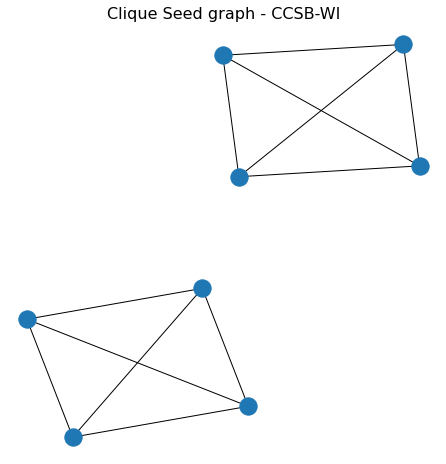

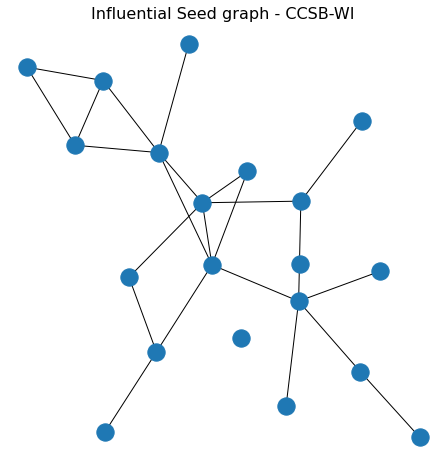

In [ ]:
plt.figure(figsize=(6,6))
nx.draw(G_seed_clique, pos = nx.kamada_kawai_layout(G_seed_clique, pos =nx.spring_layout(G_seed_clique)))
plt.title("Clique Seed graph - CCSB-WI", fontsize = 16)
plt.savefig("cliqueseedgraph")
plt.show()

plt.figure(figsize=(6,6))
nx.draw(G_seed_inf, pos = nx.kamada_kawai_layout(G_seed_inf, pos =nx.spring_layout(G_seed_inf)))
plt.title("Influential Seed graph - CCSB-WI", fontsize = 16)
plt.savefig("infseedgraph")
plt.show()

# Network-Centrality

In [ ]:
from networkx.algorithms.centrality import eigenvector_centrality, katz_centrality, \
closeness_centrality, information_centrality, harmonic_centrality, percolation_centrality, \
betweenness_centrality, degree_centrality, trophic_levels

from sklearn.decomposition import PCA
from numpy.linalg import norm

In [ ]:
# cent_func_list = [eigenvector_centrality, katz_centrality, closeness_centrality, 
#                   information_centrality, harmonic_centrality, percolation_centrality,
#                   betweenness_centrality, degree_centrality]


def comp_NCMatrix(G, cent_func_list): 
  dic_list = []
  
  for func in cent_func_list:
    try:
      seq = func(G)
      dic_list.append(seq)
    except:
      print(f"{func} not working")
  
  def dict2arr():
    nodes = [k for k in dic_list[0]]
    arr = np.zeros((len(nodes),len(dic_list)))
    for dic_idx,dic in enumerate(dic_list):
      arr[:,dic_idx] = [v for k,v in dic.items()]
    return arr
  
  CN = dict2arr()

  return CN

def ret_PCA(arr):
  pca = PCA(n_components=2)
  pca.fit(arr)
  arr_trans = pca.fit_transform(arr)
  return arr_trans, pca

def CNPCA(G, cent_func_list, pca_model=None):
  CN_G = comp_NCMatrix(G, cent_func_list)
  if pca_model is None:
    CN_G_trans, pca = ret_PCA(CN_G)
    return CN_G_trans, pca
  else:
    return pca_model.fit_transform(CN_G)

In [ ]:
cent_func_list = [closeness_centrality, 
                  betweenness_centrality, degree_centrality
                  ]

CN_Gorg_trans, pca_model = CNPCA(G_orig, cent_func_list, None)

CN_Ginf_trans_list = []
CN_Gclq_trans_list = []
for idx in range(num_realisations):
  CN_Ginf_trans = CNPCA(G_list_inf[idx], cent_func_list, pca_model)
  CN_Ginf_trans_list.append(CN_Ginf_trans)
  CN_Gclq_trans = CNPCA(G_list_clique[idx], cent_func_list, pca_model)
  CN_Gclq_trans_list.append(CN_Gclq_trans)


# CN_Ginf_trans = CNPCA(G_inf, cent_func_list, pca_model)
# CN_Gclq_trans = CNPCA(G_clique, cent_func_list, pca_model)

# CN_Ginf_trans, pca_model = CNPCA(G_inf, cent_func_list, None)
# CN_Gclq_trans, pca_model = CNPCA(G_clique, cent_func_list, None)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors

def sim_func(G1,G2,title):
  G1 = np.squeeze(G1)
  G2 = np.squeeze(G2)
  sim = abs(np.dot(G1.T, G2)/(norm(G1)*norm(G2)))
  # sim = abs(np.dot(G1.T, G2))
  # sim = sklearn.metrics.mutual_info_score(G1,G2)
  # sim = np.exp(2*sim)/(1+np.exp(-2*sim))

  return sim

def distance_func(dist, pt):
  return np.abs(np.asarray(dist) - pt) 

def _region_plot(ax, dist, color_idx = 0, label = "Original", alpha_mult = 1.0):
  N = dist.shape[0]
  
  xstd = np.std(dist[:,0])
  ystd = np.std(dist[:,1])
  thrx = 0.075 * xstd
  thry = 0.075 * ystd
  pt_list = []
  pt_list.append(dist[0,:])
  for idx in range(N):
    pt = dist[idx,:].reshape((1,2))
    distances = distance_func(pt_list, pt)
    minx = np.min(distances[:,0])
    miny = np.min(distances[:,1])
    if minx >= thrx or miny >= thry:
      pt_list.append(pt[0,:])
    # if ((idx + 1) % 5000 == 0):
      # print(f"Iteration {idx+1}, These many points found: {len(pt_list)}")

  pt_list = np.asarray(pt_list)

  dist_factor_list = []
  for idx in range(len(pt_list)):
    pt = pt_list[idx,:].reshape((1,2))
    distances = distance_func(pt_list, pt)
    distances = distances + (distances == 0) * 1000
    minx = np.min(distances[:,0])
    miny = np.min(distances[:,1])
    dist_factor_list.append(np.linalg.norm([minx / thrx, miny / thry]))

  # print(f"These many points found: {len(pt_list)}")

  size_factor = (dist_factor_list - np.min(dist_factor_list)) / np.max(dist_factor_list)
  pt_sizes = (20**2 - (19**2) * size_factor).tolist()

  alpha_sizes = (0.125 - 0.1 * size_factor) * alpha_mult

  c=f'C{color_idx}'
  color_list = list((*colors.to_rgb(c),0))
  color_list = [color_list] * len(pt_sizes)
  color_list = np.asarray(color_list)
  color_list[:,3] = alpha_sizes

  # print(*colors.to_rgb(c))
  ax.scatter(pt_list[:,0], pt_list[:,1], c = color_list, edgecolors = 'none', s= pt_sizes)

def sim_plot(ax, dist_list, orig, title, subset = 1.0, seed = 0):
  state = np.random.get_state()
  np.random.seed(seed)
  dist_list = np.asarray(dist_list)
  if (subset < 1.0):
    dist_list = dist_list[np.random.choice(dist_list.shape[0], int(dist_list.shape[0] * subset), replace=False), :]
  ax.scatter(dist_list[:,:,0].flatten(), dist_list[:,:,1].flatten(), alpha = 0.25, s= 8,edgecolors = 'none', label = 'Generated')
  ax.scatter(orig[:,0], orig[:,1], alpha = 0.5, s = 8,edgecolors = 'none', label = 'Original')
  ax.set_title(title, fontsize = 16)
  leg = ax.legend()
  for lh in leg.legendHandles: 
    lh.set_alpha(1)
  np.random.set_state(state)

# sim_plot(CN_Ginf_trans_list,CN_Gorg_trans, title = "Inf vs Orig")
# sim_plot(CN_Gclq_trans_list,CN_Gorg_trans, title = "Cliq vs Orig")


# print(f"Similarity Score using Influential seed : {sim_inf}")
# print(f"Similarity Score using Max clique seed: {sim_clique}")

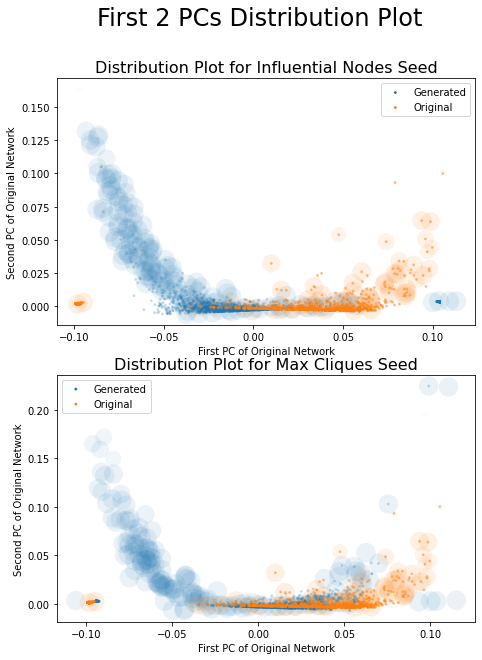

In [ ]:
def plot_region(ax, dist_list, color_idx = 0, label = "Original", alpha_mult = 1.0):
  dist_array = np.asarray(dist_list)
  dist_rshp = dist_array.reshape((-1, 2))
  _region_plot(ax, dist_rshp, color_idx, label, alpha_mult = alpha_mult)


fig, axs = plt.subplots(2, 1, figsize = (7.5,10))
ax = axs[0]
plot_region(ax, CN_Gorg_trans, color_idx = 1, alpha_mult=1.0)
plot_region(ax, CN_Ginf_trans_list, color_idx = 0, alpha_mult=0.75)
sim_plot(ax, CN_Ginf_trans_list,CN_Gorg_trans, title = "Distribution Plot for Influential Nodes Seed", subset = 0.05, seed = 1)
ax.set_xlabel("First PC of Original Network")
ax.set_ylabel("Second PC of Original Network")

ax = axs[1]
plot_region(ax, CN_Gclq_trans_list, color_idx = 0, alpha_mult=0.75)
plot_region(ax, CN_Gorg_trans, color_idx = 1, alpha_mult=1.0)
sim_plot(ax, CN_Gclq_trans_list,CN_Gorg_trans, title = "Distribution Plot for Max Cliques Seed", subset = 0.05, seed = 1)
ax.set_xlabel("First PC of Original Network")
ax.set_ylabel("Second PC of Original Network")

plt.suptitle("First 2 PCs Distribution Plot", fontsize = 24)
plt.savefig("pcdistplot")
plt.show()

In [ ]:
from scipy import stats
infpc1 = np.asarray(CN_Ginf_trans_list).reshape((-1, 2))[:,0]
clqpc1 = np.asarray(CN_Gclq_trans_list).reshape((-1, 2))[:,0]
orgpc1 = np.asarray(CN_Gorg_trans)[:,0]

print("KS Test statistic for Influential vs Original")
print(stats.ks_2samp(infpc1, orgpc1).statistic)
print("Corresponding pvalue")
print(stats.ks_2samp(infpc1, orgpc1).pvalue)
print("KS Test statistic for MaxCliq vs Original")
print(stats.ks_2samp(clqpc1, orgpc1).statistic)
print("Corresponding pvalue")
print(stats.ks_2samp(clqpc1, orgpc1).pvalue)

KS Test statistic for Influential vs Original
0.44826435246995994
Corresponding pvalue
1.9845309826749168e-249
KS Test statistic for MaxCliq vs Original
0.4007009345794393
Corresponding pvalue
2.165920585724016e-199


# Analysis

In [ ]:
import sklearn
import numpy as np
from scipy.stats import entropy

In [ ]:
# G_seed = G_seed_clique
# num_realisations = 20
# G_list = []
# for idx in range(num_realisations):
#     G = gen_network(G_seed,G_orig,node_remove_prob_clique,node_create_prob_clique,seed = idx, delete_singleton = delete_singleton)
#     G_list.append(G)

In [ ]:
# num_realisations = 20
# G_list_clique = []
# G_list_inf = []
# for idx in range(num_realisations):
#     G = gen_network(G_seed_clique,G_orig,node_remove_prob_clique,node_create_prob_clique,seed = idx, delete_singleton = delete_singleton)
#     G_list_clique.append(G)   
#     G = gen_network(G_seed_inf,G_orig,node_remove_prob_inf,node_create_prob_inf,seed = idx, delete_singleton = delete_singleton)
#     G_list_inf.append(G) 

In [ ]:
# for idx in range(num_realisations):
#   print(f"#### Generated network {idx+1} #####")
#   print(nx.info(G_list[idx]))
# print()
# print("#### Original network #####")
# print(nx.info(G_orig))

In [ ]:
# mean_edges = np.mean([len(G_list[idx].edges) for idx in range(num_realisations)])
# print(f"Mean edges across {num_realisations} realisations: {int(mean_edges)}")
# avg_deg_list = []
# for idx in range(num_realisations):
#   avg_deg = np.mean([d for n,d in G_list[idx].degree()])
#   avg_deg_list.append(avg_deg)
# print(f"Mean avg degree across {num_realisations} realisations: {(np.mean(avg_deg_list))}")

## Degree Distribution

In [ ]:
def compare_plots(dist_func, title = "Degree Centrality", logy = False):
  plt.style.use('seaborn-deep')
  deg_list_clique = []
  for idx in range(num_realisations):
    degree_sequence = sorted([d for n, d in dist_func(G_list_clique[idx]).items()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    deg_list_clique.extend(list(deg))

  deg_list_inf = []
  for idx in range(num_realisations):
    degree_sequence = sorted([d for n, d in dist_func(G_list_inf[idx]).items()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    deg_list_inf.extend(list(deg))

  fig, axs = plt.subplots(1,1, figsize = (7.5, 7.5), sharey = False)
  ca = axs

  degree_sequence = sorted([d for n, d in dist_func(G_orig).items()], reverse=True)  # degree sequence
  degreeCount = collections.Counter(degree_sequence)
  deg_list_orig, cnt = zip(*degreeCount.items())

  bins = 12
  min_deg = min([min(deg_list_orig), min(deg_list_clique), min(deg_list_inf)])
  max_deg = max([max(deg_list_orig), max(deg_list_clique), max(deg_list_inf)])

  bins = np.linspace(min_deg, max_deg, bins)

  dists = [deg_list_orig, deg_list_clique, deg_list_inf]
  labels = ['Original Network', 'Max Clique Seed', 'Influential Nodes Seed']

  # plot the normalized frequencies
  ca.hist(dists, bins, rwidth= 0.7, linewidth=1, edgecolor='white', density = True, label = labels)
  ca.set_title(f"Comparison of {title} Distribution", fontsize = 16)
  ca.set_ylabel("Frequency", fontsize = 16)
  ca.set_xlabel(f"{title}", fontsize = 16)
  ca.legend()
  if (logy):
    ca.set_yscale('log', nonposy='clip')

  plt.savefig(f"{title}.png")
  plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


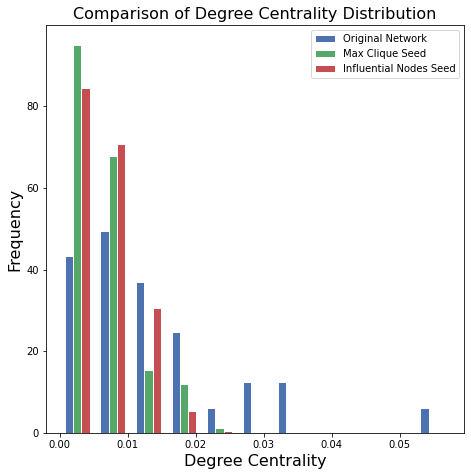

In [ ]:
compare_plots(nx.degree_centrality, title = "Degree Centrality")

In [ ]:
# ent_list = []
# dist2 = np.array(sorted([d for n, d in nx.degree_centrality(G_orig).items()], reverse=True))
# dist2 = dist2/sum(dist2)
# for idx in range(num_realisations):
#   G = G_list[idx]
#   dist1 = np.array(sorted([d for n, d in nx.degree_centrality(G).items()], reverse=True))
#   dist1 = dist1/sum(dist1)
#   ent = entropy(pk=dist1,qk=dist2)
#   if not(np.isinf(ent)):
#     ent_list.append(abs(ent))
# print(f"Average entropy for degree centrality distribution: {np.mean(ent_list)}")

## Betweeness centrality

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


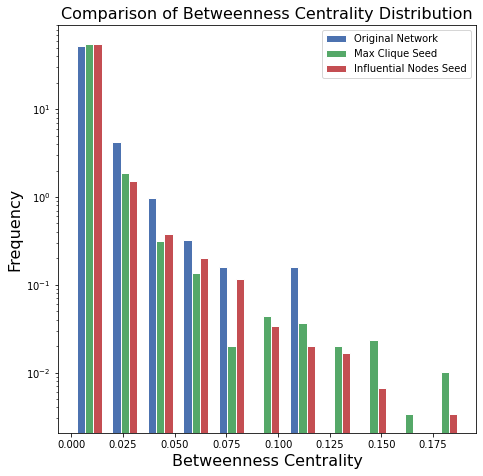

In [ ]:
compare_plots(nx.betweenness_centrality, "Betweenness Centrality", True)

In [ ]:
# ent_list = []
# dist2 = np.array(sorted([d for n, d in nx.betweenness_centrality(G_orig).items()], reverse=True))
# dist2 = dist2/sum(dist2)
# for idx in range(num_realisations):
#   G = G_list[idx]
#   dist1 = np.array(sorted([d for n, d in nx.betweenness_centrality(G).items()], reverse=True))
#   dist1 = dist1/sum(dist1)
#   ent = entropy(pk=dist1,qk=dist2)
#   if not(np.isinf(ent)):
#     ent_list.append(abs(ent))
# print(f"Average entropy for betweenness centrality distribution: {np.mean(ent_list)}")

## Closeness centrality

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


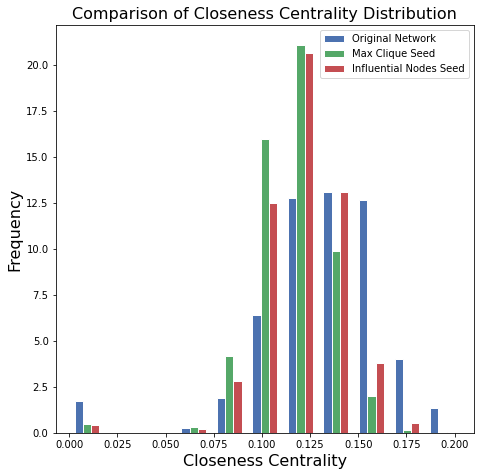

In [ ]:
compare_plots(nx.closeness_centrality, "Closeness Centrality")

In [ ]:
# ent_list = []
# dist2 = np.array(sorted([d for n, d in nx.closeness_centrality(G_orig).items()], reverse=True))
# dist2 = dist2/sum(dist2)
# for idx in range(num_realisations):
#   G = G_list[idx]
#   dist1 = np.array(sorted([d for n, d in nx.closeness_centrality(G).items()], reverse=True))
#   dist1 = dist1/sum(dist1)
#   ent = entropy(pk=dist1,qk=dist2)
#   ent_list.append(abs(ent))
# print(f"Average entropy for closeness centrality distribution: {np.mean(ent_list)}")